## Advanced Lane Finding

### Importing modules

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

### Calibrating Camera

#### Test pipeline withe one calibration image

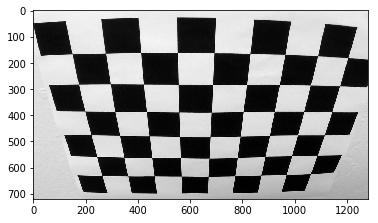

In [2]:
# Read in an image
img = cv2.imread('camera_cal/calibration2.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

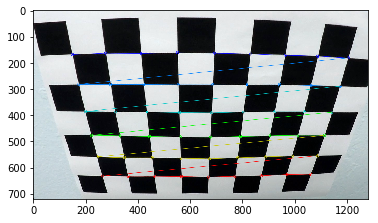

In [3]:
# Prepare object points
nx = 9
ny = 6

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

In [4]:
# Calibrate camera

# Create object and image points for calibration
objpoints = [];
imgpoints = [];

objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

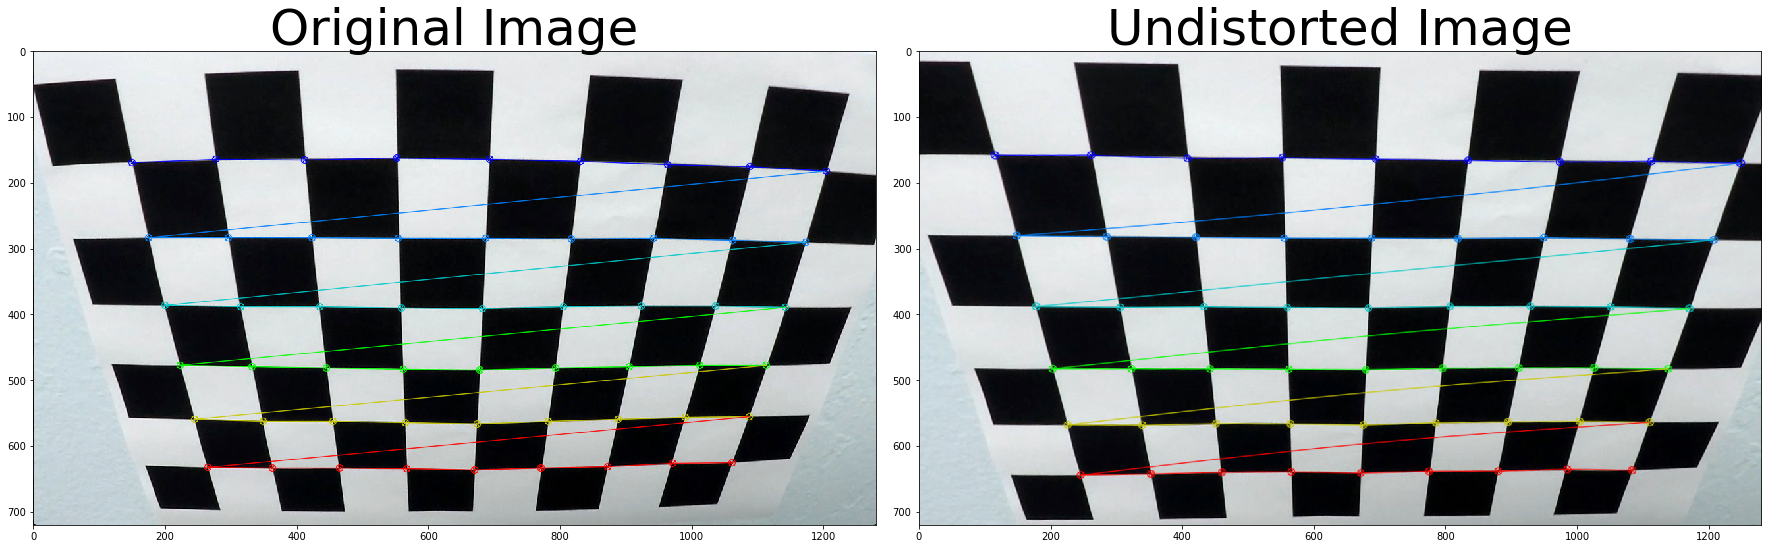

In [5]:
def visualize_pair(image1,image2,title1,title2):
    # Visualize original and undistorted image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# Undistort image
undistorted = cv2.undistort(img,mtx,dist,None,mtx)

# Visualize image
visualize_pair(img, undistorted, 'Original Image', 'Undistorted Image')

#### Run calibration for all images

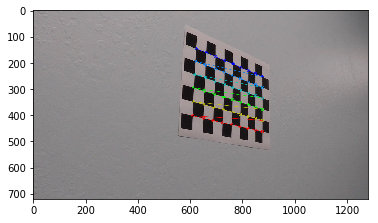

In [6]:
# Read a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Create object and image points for calibration
objpoints = [];
imgpoints = [];

objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    # Read in an image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If corners are found, add points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save calibration parameters
with open('calib.pkl', 'wb') as f:
    pickle.dump([ret, mtx, dist, rvecs, tvecs], f)

#### Test calibration results

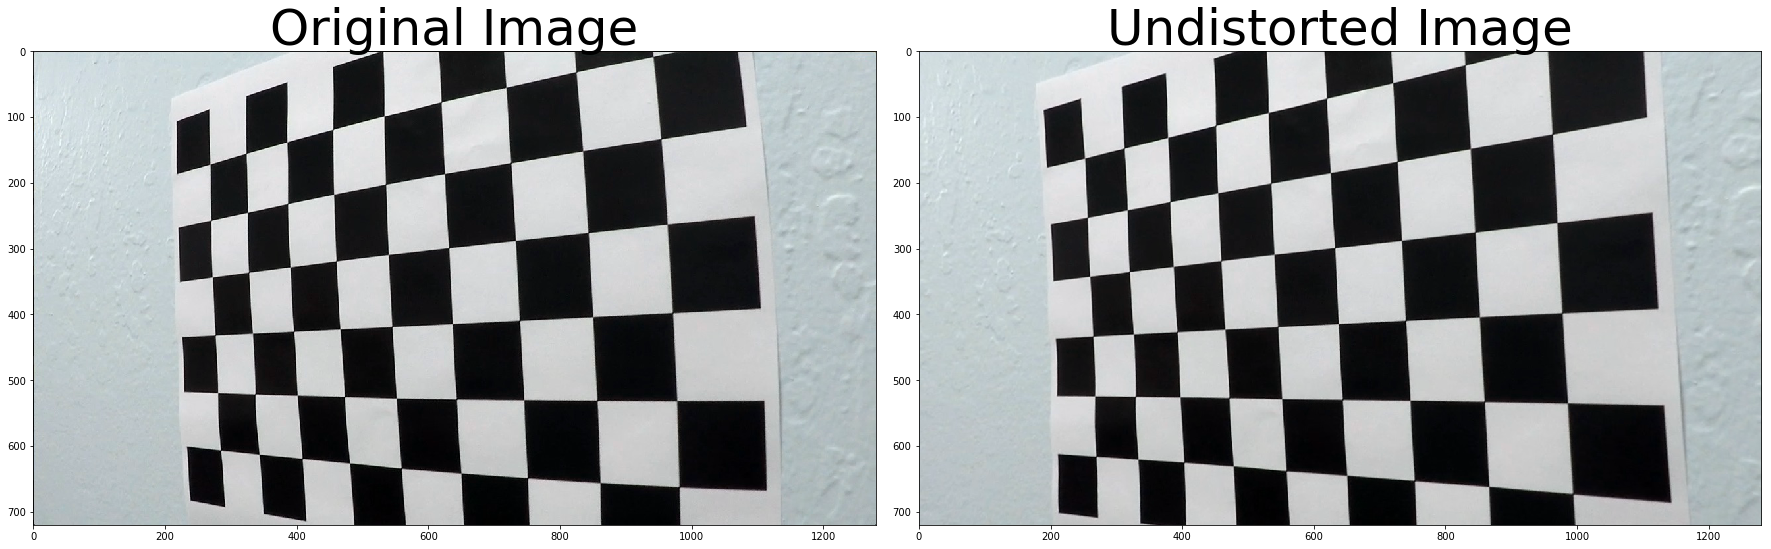

In [7]:
# Read in an image
img = cv2.imread('camera_cal/calibration4.jpg')
    
# Undistort image
undistorted = cv2.undistort(img,mtx,dist,None,mtx)

# Visualize original and undistorted image
visualize_pair(img, undistorted, 'Original Image', 'Undistorted Image')

### Thresholding

#### Test pipeline withe one image

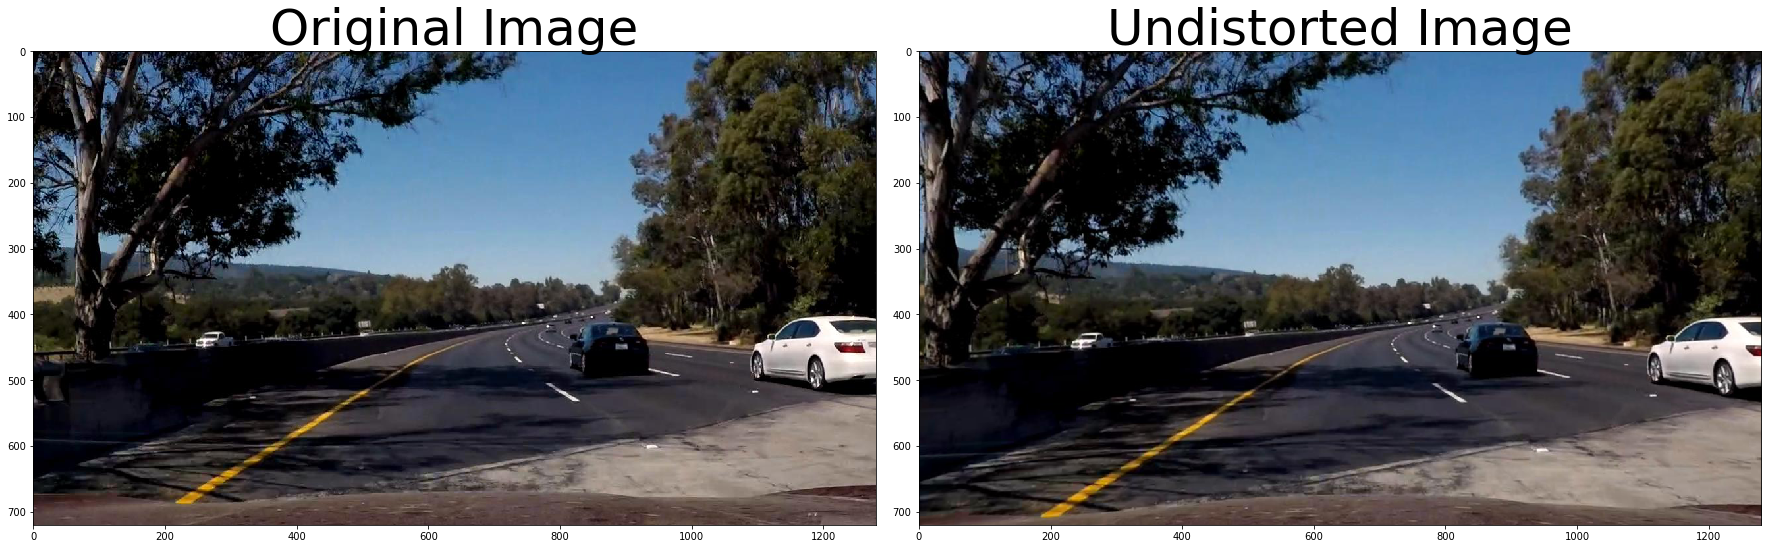

In [22]:
# Read in an image
# img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/test7.jpg')

# Convert to RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
# Undistort image
undistorted = cv2.undistort(img,mtx,dist,None,mtx)

# Visualize original and undistorted image
visualize_pair(img, undistorted, 'Original Image', 'Undistorted Image')

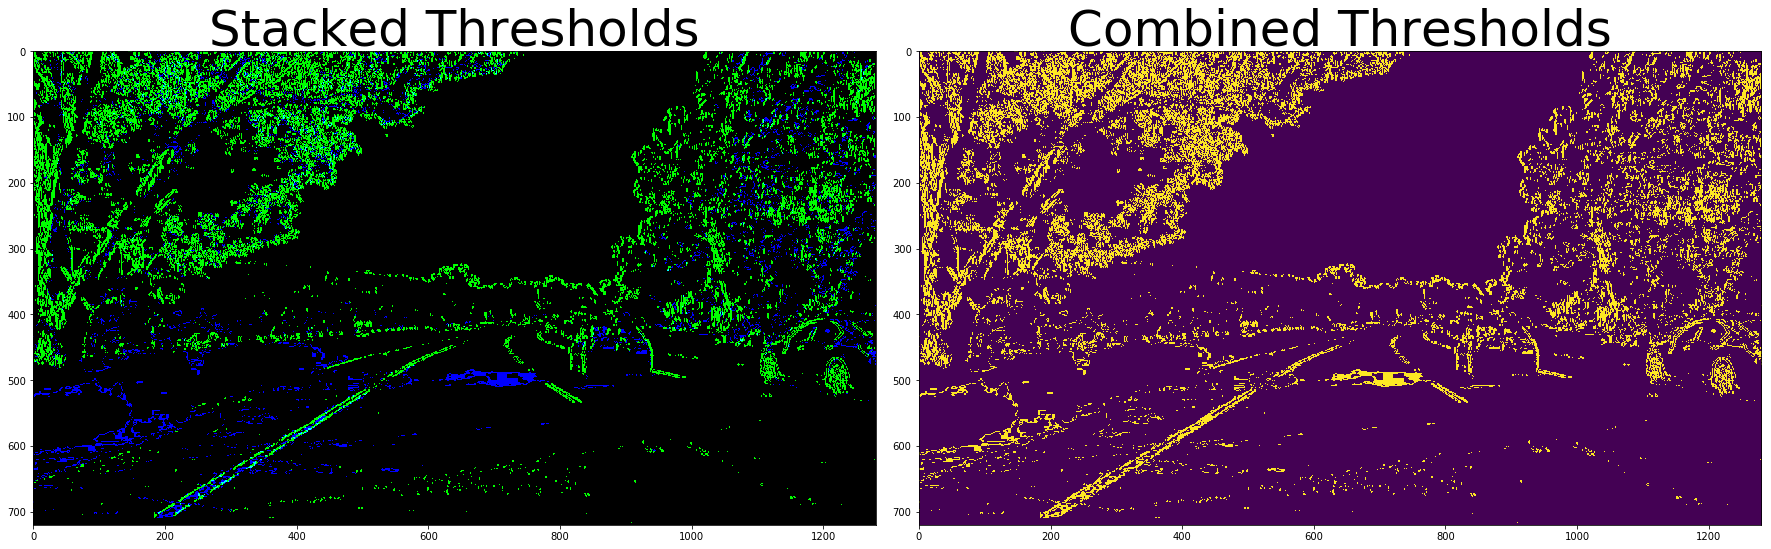

In [27]:
def threshold_image(undistorted):
    
    # Convert to HLS
    hls = cv2.cvtColor(undistorted,cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 220
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Grayscale image
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

# Threshold image
color_binary, combined_binary = threshold_image(undistorted)

# Plotting thresholded images
visualize_pair(color_binary, combined_binary, 'Stacked Thresholds', 'Combined Thresholds')

### Applying Perspective Transform

#### Test pipeline withe one image

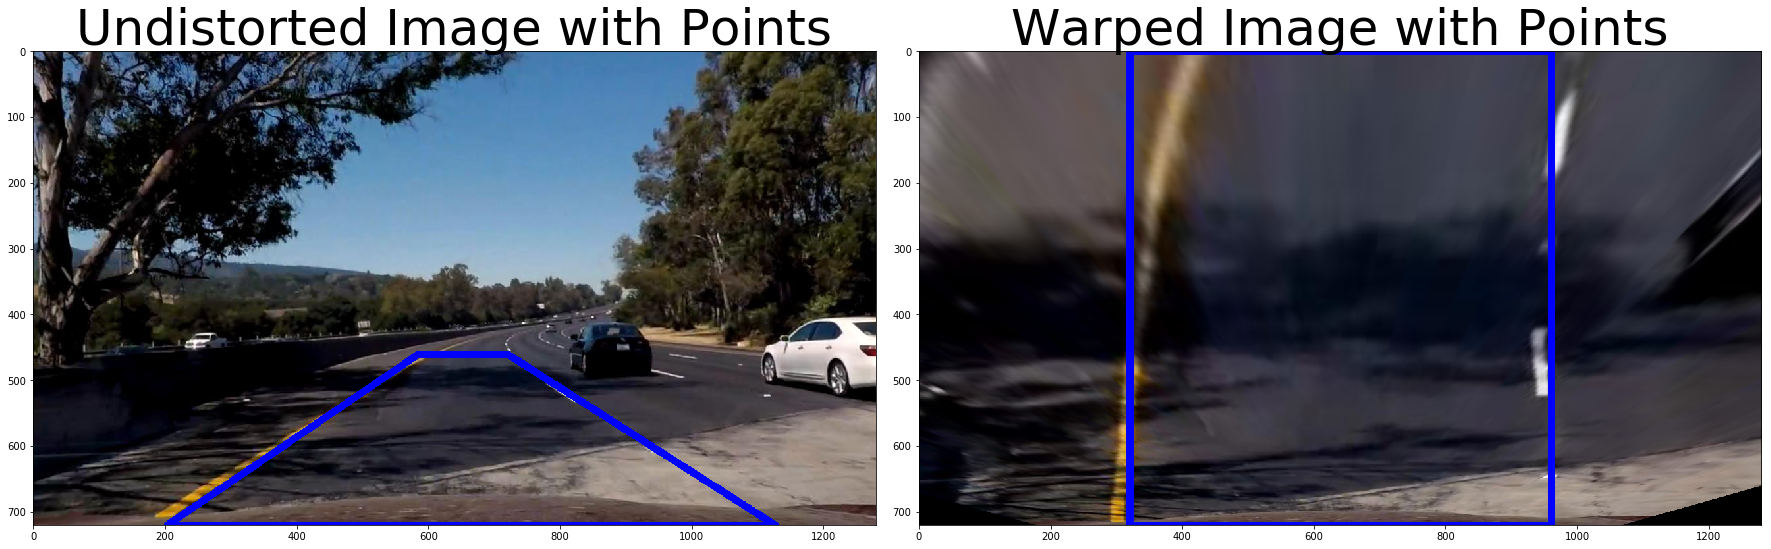

In [28]:
def warp_image(undistorted):
    
    # Create src and dst points for perspective transform

    # Create source points
    imshape = undistorted.shape
#     apex = 450
#     lo = 250
#     lm = 550
#     rm = 725
#     ro = 1250
    apex = 460
    lo = 203
    lm = 585
    rm = 720
    ro = 1127
    src = np.array([[(lm,apex), 
                     (lo,imshape[0]), 
                     (ro,imshape[0]), 
                     (rm,apex)]], dtype=np.float32)
    srcdp = np.array([[(lm,apex,lo,imshape[0]),
                       (lo,imshape[0],ro,imshape[0]), 
                       (ro,imshape[0],rm,apex), 
                       (rm,apex,lm,apex)]], dtype=np.int32)

    undist_roi_image = np.copy(undistorted) 
    for vertex in srcdp:
        for x1,y1,x2,y2 in vertex:
            cv2.line(undist_roi_image,(x1,y1),(x2,y2),(0,0,255),10)

    # Create destination points
    img_size = (gray.shape[1], gray.shape[0])
    dst = np.float32([[(img_size[0] / 4), 0],
                      [(img_size[0] / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), 0]])
    dstdp = np.array([[((img_size[0] / 4), 0, (img_size[0] / 4), img_size[1]),
                     ((img_size[0] / 4), img_size[1], (img_size[0] * 3 / 4), img_size[1]),
                     ((img_size[0] * 3 / 4), img_size[1], (img_size[0] * 3 / 4), 0),
                     ((img_size[0] * 3 / 4), 0, (img_size[0] / 4), 0)]], dtype=np.int32)
#     offset = 0
#     dst = np.float32([[offset, img_size[1]-offset],
#                       [offset, offset], 
#                       [img_size[0]-offset, offset], 
#                       [img_size[0]-offset, img_size[1]-offset]])
#     dstdp = np.array([[(offset, img_size[1]-offset, offset, offset),
#                        (offset, offset, img_size[0]-offset, offset),
#                        (img_size[0]-offset, offset, img_size[0]-offset, img_size[1]-offset),
#                        (img_size[0]-offset, img_size[1]-offset, offset, img_size[1]-offset)]], dtype=np.int32)
#     print(src)
#     print(dst)

    # Estimate perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Estimate inverse transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp image to get the transformed image
    warped = cv2.warpPerspective(undistorted, M, img_size)

    warp_roi_image = np.copy(warped) 
    for vertex in dstdp:
        for x1,y1,x2,y2 in vertex:
            cv2.line(warp_roi_image,(x1,y1),(x2,y2),(0,0,255),10)
    
#     with open('transf.pkl', 'wb') as f:
#         pickle.dump([undistorted, img_size, M, Minv], f)
        
    return warped, warp_roi_image, undist_roi_image

# Warp image
warped, warp_roi_image, undist_roi_image = warp_image(undistorted)

# Visualize result
visualize_pair(undist_roi_image, warp_roi_image, 'Undistorted Image with Points', 'Warped Image with Points')

### Fitting Polynomial

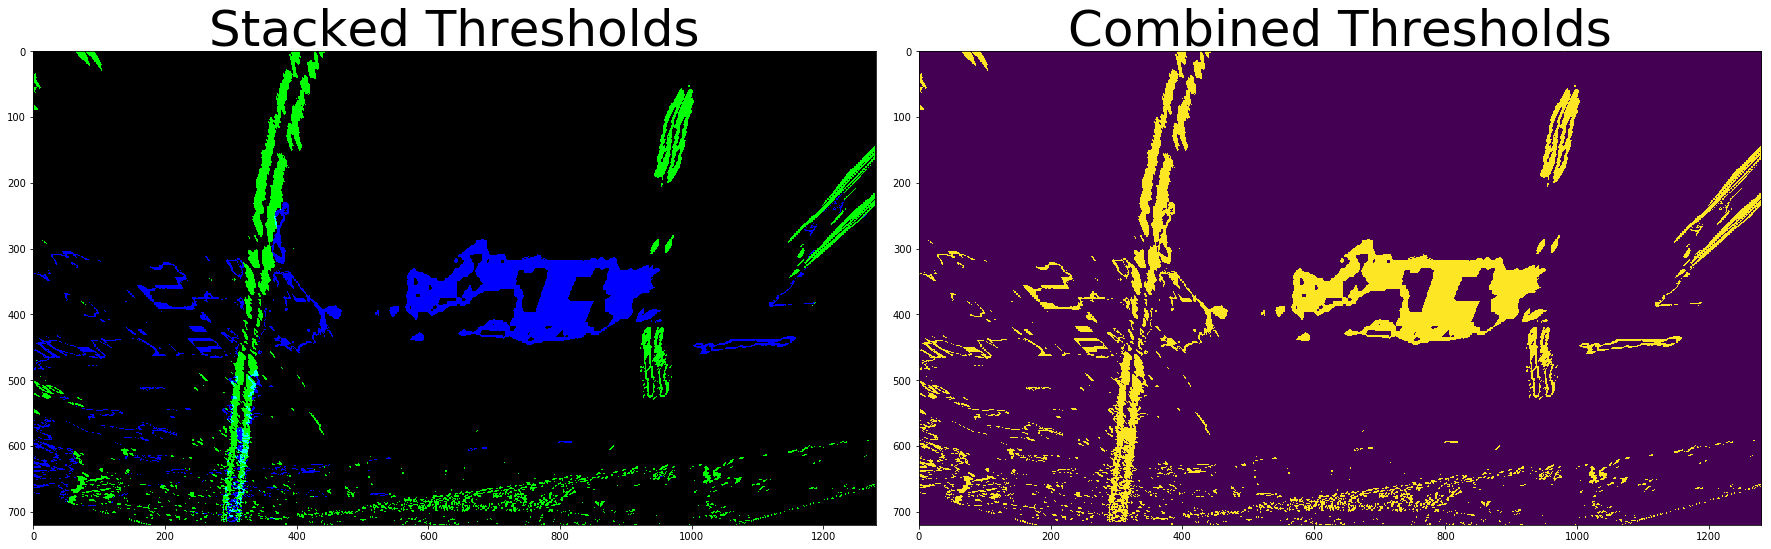

In [29]:
# Threshold warped image
color_warped, binary_warped = threshold_image(warped)

# Plotting thresholded images
visualize_pair(color_warped, binary_warped, 'Stacked Thresholds', 'Combined Thresholds')

(720, 0)

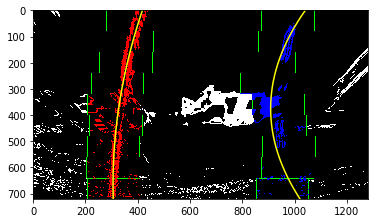

In [30]:
def fit_lanes(binary_warped):
    
    # Take a histogram of the bottom half of the image
    idx = np.int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[idx:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    left_margin = 100 # np.int(histogram.shape[0]/4)
    right_margin = 1200 # np.int(3*histogram.shape[0]/4)
    leftx_base = np.argmax(histogram[left_margin:midpoint]) + left_margin
    rightx_base = np.argmax(histogram[midpoint:right_margin]) + midpoint
#     print(midpoint)
#     print(left_margin)
#     print(right_margin)
#     print(histogram[left_margin:midpoint].shape)
#     print(histogram[midpoint:right_margin].shape)
#     print(leftx_base)
#     print(rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    
    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx

out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = fit_lanes(binary_warped)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Measuring Curvature

In [31]:
def measure_curvature(left_fit, right_fit, plot_y, leftx, rightx):
    # Define y-value where we want radius of curvature
    # Let's choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print('Left R (pixels): ', left_curverad, 'Right R (pixels): ',  right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)
# Now our radius of curvature is in meters
print('Left R (m): ', left_curverad, 'Right R (m): ',  right_curverad)


Left R (m):  649.499457919 Right R (m):  176.345152928


### Projecting lines back

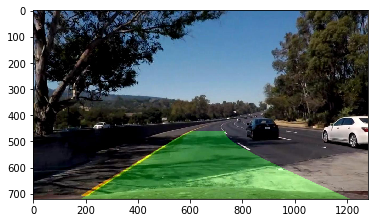

In [32]:
def project_back(warped, ploty, left_fitx, right_fitx, undistorted, img_size, Minv):
    # Create an image to draw the lines on
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    warp_zero = np.zeros_like(gray).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.transpose(np.vstack([left_fitx, ploty]))
    pts_right = np.flipud(np.transpose(np.vstack([right_fitx, ploty])))
    pts = np.vstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

# Load transforms
with open('transf.pkl', 'rb') as f:  
    undistortedk, img_size, M, Minv = pickle.load(f)
    
result = project_back(warped, ploty, left_fitx, right_fitx, undistorted, img_size, Minv)
plt.imshow(result)

### Testing on video

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

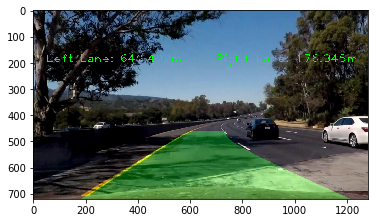

In [34]:
def process_image(img):
    
    # Undistort
    undistorted = cv2.undistort(img, process_image.mtx, process_image.dist, None, process_image.mtx)
    
    # Warp
#     img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(undistorted, process_image.M, process_image.img_size)
    
    # Threshold
    color_warped, binary_warped = threshold_image(warped)

    # Fit lanes
    out_img, left_fit, right_fit, ploty, left_fitx, right_fitx = fit_lanes(binary_warped)
    
    # Measure curvature
    left_curverad, right_curverad = measure_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)
    
    # Project back
    projected = project_back(warped, ploty, left_fitx, right_fitx, undistorted, process_image.img_size, process_image.Minv)
    
    # Add curvature measurement as text
    leftlabel = str(left_curverad)
    rightlabel = str(right_curverad)
    result = cv2.putText(projected, 'Left Lane: ' + leftlabel[0:7] + 'm', (50, 200), cv2.FONT_HERSHEY_PLAIN, 3, (0,255,0), 2);
    result = cv2.putText(result, 'Right Lane: ' + rightlabel[0:7] + 'm', (700, 200), cv2.FONT_HERSHEY_PLAIN, 3, (0,255,0), 2);
            
    return result

# Load calibration parameters
with open('calib.pkl', 'rb') as f:  
    process_image.ret, process_image.mtx, process_image.dist, process_image.rvecs, process_image.tvecs = pickle.load(f)
    
# Load transforms
with open('transf.pkl', 'rb') as f:  
    process_image.undistorted, process_image.img_size, process_image.M, process_image.Minv = pickle.load(f)

# Test pipeline
result = process_image(img)
plt.imshow(result)

In [37]:
project_output = 'test_videos_output/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(35,45)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_output.mp4
[MoviePy] Writing video test_videos_output/project_output.mp4


100%|██████████████████████████████▉| 1260/1261 [04:48<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_output.mp4 

Wall time: 4min 51s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="test_videos_output/project_output.mp4" type="video/mp4">
</video>
""".format(project_output))

In [21]:
clip1.save_frame('test_images/test7.jpg',6.5)